# Benchmarking

We compare simulation times with original SBMLtoODEpy.
We compare (i) loop (ii) multiprocessing (iii) jax vmap
This notebook is rather complicated so you can jump to the results.

## Imports and Utils 

In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")
warnings.warn("test")

import jax
jax.config.update("jax_platform_name", "cpu")
from jax import vmap
import jax.numpy as jnp
import jax.random as jrandom

import importlib
import os
import time

import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
from sbmltoodejax.biomodels_api import get_content_for_model
from sbmltoodejax.parse import ParseSBMLFile
from sbmltoodejax.modulegeneration import GenerateModel as GenerateJaxModel
from sbmltoodepy.modulegeneration import GenerateModel as GeneratePyModel

In [2]:
def generate_models(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12, mxstep=1000):
    
    model_xml_body = get_content_for_model(model_idx)
    model_data = ParseSBMLFile(model_xml_body)
    
    py_model_fp = "py_model.py"
    GeneratePyModel(model_data, py_model_fp)
    
    jax_model_fp = "jax_model.py"
    GenerateJaxModel(model_data, jax_model_fp, deltaT=deltaT, atol=atol, rtol=rtol)
    
    return py_model_fp, jax_model_fp

def load_models(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12, mxstep=1000):
    # Generate model files
    py_model_fp, jax_model_fp = generate_models(model_idx, deltaT=deltaT, atol=atol, rtol=rtol, mxstep=mxstep)
    
    # Load Jax model
    jax_spec = importlib.util.spec_from_file_location("ModelSpec", jax_model_fp)
    jax_module = importlib.util.module_from_spec(jax_spec)
    jax_spec.loader.exec_module(jax_module)
    
    jax_model_cls = getattr(jax_module, "ModelRollout")
    jax_model = jax_model_cls()
    jax_y0 = getattr(jax_module, "y0")
    jax_w0 = getattr(jax_module, "w0")
    jax_c = getattr(jax_module, "c")
    
    y_indexes = getattr(jax_module, "y_indexes")
    w_indexes = getattr(jax_module, "w_indexes")
    c_indexes = getattr(jax_module, "c_indexes")
    
    
    # Load numpy model
    py_spec = importlib.util.spec_from_file_location("ModelSpec", py_model_fp)
    py_module = importlib.util.module_from_spec(py_spec)
    py_spec.loader.exec_module(py_module)
    
    py_model_cls = getattr(py_module, "SBMLmodel")
    py_model = py_model_cls()
    py_y0, py_w0, py_c = get_sbmltoodepy_model_variables(py_model, y_indexes, w_indexes, c_indexes)


    return (jax_model, jax_y0, jax_w0, jax_c), (py_model, py_y0, py_w0, py_c), (y_indexes, w_indexes, c_indexes)

In [3]:
def get_sbmltoodepy_model_variables(model, y_indexes, w_indexes, c_indexes):
    y = np.zeros(len(y_indexes))
    w = np.zeros(len(w_indexes))
    c = np.zeros(len(c_indexes))

    for k, v in model.s.items():
        if k in y_indexes:
            y[y_indexes[k]] = v.amount
        elif k in w_indexes:
            w[w_indexes[k]] = v.amount
        elif k in c_indexes:
            c[c_indexes[k]] = v.amount

    for k, v in model.p.items():
        if k in y_indexes:
            y[y_indexes[k]] = v.value
        elif k in w_indexes:
            w[w_indexes[k]] = v.value
        elif k in c_indexes:
            c[c_indexes[k]] = v.value

    for k, v in model.c.items():
        if k in y_indexes:
            y[y_indexes[k]] = v.size
        elif k in w_indexes:
            w[w_indexes[k]] = v.size
        elif k in c_indexes:
            c[c_indexes[k]] = v.size

    for k, v in model.r.items():
        for sub_k, sub_v in v.p.items():
            if f"{k}_{sub_k}" in w_indexes:
                w[w_indexes[f"{k}_{sub_k}"]] = sub_v.value
            elif f"{k}_{sub_k}" in c_indexes:
                c[c_indexes[f"{k}_{sub_k}"]] = sub_v.value

    return y, w, c


def set_sbmltoodepy_model_variables(model, y, y_indexes):
    """
    Util to set the model variables
    """
    
    for k in model.s.keys():
        if k in y_indexes:
            model.s[k].concentration = y[y_indexes[k]]

    for k in model.p.keys():
        if k in y_indexes:
            model.p[k].value = y[y_indexes[k]]


    for k in model.c.keys():
        if k in y_indexes:
            model.c[k].size = y[y_indexes[k]]

    return model

In [4]:
# default colors
default_colors = [(204,121,167), 
                  (0,114,178),
                  (230,159,0),  
                  (0,158,115),
                  (127,127,127),
                  (240,228,66),
                  (148,103,189),
                  (86,180,233),
                  (213,94,0),
                  (140,86,75),
                  (214,39,40),
                  (0,0,0)]
default_colors = [tuple([c/255 for c in color]) for color in default_colors]

## Run benchmark

In [5]:
# Simulation for different (rollout durations, number of rollouts in parallel)
all_model_ids = [3, 4, 6, 8, 10]
all_n_secs = [0.1, 1, 10, 100, 1000, 10000, 100000]
all_n_in_parallel = [5, 50, 100, 250, 500, 1000]

In [6]:
# same ODE solver parameters than SBMLtoODEpy ones for fair comparison
deltaT = 0.1
atol = 1e-6
rtol = 1e-12
mxstep = 5000000 

key = jrandom.PRNGKey(0)

# prepare results dictionary
compute_time = {}
compute_time['jax'] = {}
compute_time['py'] = {}
compute_time['py_pool'] = {}
for model_idx in all_model_ids:
    compute_time['jax'][model_idx] = {}
    compute_time['py'][model_idx] = {}
    compute_time['py_pool'][model_idx] = {}
    for n_in_parallel in [1] + all_n_in_parallel: 
        compute_time['jax'][model_idx][n_in_parallel] = {}
        compute_time['py'][model_idx][n_in_parallel] = {}
        compute_time['py_pool'][model_idx][n_in_parallel] = {}


for model_idx in all_model_ids:
    print(f"model_idx: {model_idx}")
    
    # load models
    (jax_model, jax_y0, jax_w0, jax_c), (py_model, py_y0, py_w0, py_c), (y_indexes, w_indexes, c_indexes) = load_models(model_idx, deltaT=deltaT, atol=atol, rtol=rtol, mxstep=mxstep)

    
    # We first test for different n_secs without parallel execution (n_in_parallel = 1)
    n_in_parallel = 1
    for i, n_secs in enumerate(all_n_secs):
        print(f"n_secs: {n_secs}")

        n_steps = int(n_secs / deltaT)


        # Simulate JAX model
        jax_cstart = time.time()
        jax_ys, jax_ws, times = jax_model(n_steps, jax_y0, jax_w0)
        jax_ys.block_until_ready()
        jax_cend = time.time()

        compute_time['jax'][model_idx][n_in_parallel][n_secs] = jax_cend - jax_cstart

        # Simulate NUMPY model 
        if n_secs <= 1000:

            py_cstart = time.time()
            for step_idx in range(n_steps):
                py_model.RunSimulation(deltaT, absoluteTolerance=atol, relativeTolerance=rtol)
            py_cend = time.time()

            compute_time['py'][model_idx][n_in_parallel][n_secs] = py_cend - py_cstart
        
        else:
            # we do linear approximation for big n_secs (too long to run)
            prev_n_secs = all_n_secs[i-1]
            ratio = n_secs/prev_n_secs
            compute_time['py'][model_idx][n_in_parallel][n_secs] = compute_time['py'][model_idx][n_in_parallel][prev_n_secs]*ratio
        
        
    # We then test different number of simulations launched in parallel and n_secs = 10
    n_secs = 10
    n_steps = int(n_secs / deltaT)
    
    # batch jax model
    batched_jax_model = vmap(jax_model, in_axes=(None, 0, 0), out_axes=(0, 0, None))
    
    # Create batched init (by adding perturbation to default init state)
    key, subkey = jrandom.split(key)
    perturb = jrandom.uniform(subkey, (all_n_in_parallel[-1], len(jax_y0)), minval=0.0, maxval=5.0)
    batched_jax_y0 = jnp.maximum(jnp.tile(jax_y0, (all_n_in_parallel[-1], 1)) + perturb, 0.0)
    batched_jax_w0 = jnp.tile(jax_w0, (all_n_in_parallel[-1], 1))
    batched_py_y0 = np.array(batched_jax_y0)
    
    for i, n_in_parallel in enumerate(all_n_in_parallel):
        print(f"n_in_parallel: {n_in_parallel}")
    
        # Simulate JAX model
        jax_cstart = time.time()
        jax_ys, jax_ws, times = batched_jax_model(n_steps, batched_jax_y0[:n_in_parallel], batched_jax_w0[:n_in_parallel])
        jax_ys.block_until_ready()
        jax_cend = time.time()
        
        compute_time['jax'][model_idx][n_in_parallel][n_secs] = jax_cend - jax_cstart
        
        # Simulate NUMPY model with for loop over init states
        if n_in_parallel <= 100:
        
            py_ctime = 0
            for cur_py_y0 in batched_py_y0[:n_in_parallel]:

                # Change initial state 
                py_model = set_sbmltoodepy_model_variables(py_model, cur_py_y0, y_indexes)

                # Run simulation
                py_cstart = time.time()
                for step_idx in range(n_steps):
                    py_model.RunSimulation(deltaT, absoluteTolerance=atol, relativeTolerance=rtol)
                py_cend = time.time()

                py_ctime += py_cend - py_cstart

            compute_time['py'][model_idx][n_in_parallel][n_secs] = py_ctime
        
        else:
            # we do linear approximation for big n_in_parallel (too long to run)
            prev_n_in_parallel = all_n_in_parallel[i-1]
            ratio = n_in_parallel/prev_n_in_parallel
            compute_time['py'][model_idx][n_in_parallel][n_secs] = compute_time['py'][model_idx][prev_n_in_parallel][n_secs]*ratio
        
        
        # Simulate NUMPY model with pooling over init states
        def simulate_py_model(cur_py_y0):
            # Change initial state 
            cur_py_model = set_sbmltoodepy_model_variables(py_model, cur_py_y0, y_indexes)

            # Run simulation
            for step_idx in range(n_steps):
                cur_py_model.RunSimulation(deltaT, absoluteTolerance=atol, relativeTolerance=rtol)

            return

        # Simulate the OOP Numpy/Scipy-based Model
        py_cstart = time.time()
        p = Pool()
        res = p.map(simulate_py_model, [cur_py_y0 for cur_py_y0 in batched_py_y0[:n_in_parallel]])
        py_cend = time.time()
        
        compute_time['py_pool'][model_idx][n_in_parallel][n_secs] = py_cend - py_cstart

model_idx: 3
n_secs: 0.1
n_secs: 1
n_secs: 10
n_secs: 100
n_secs: 1000
n_secs: 10000
n_secs: 100000
n_in_parallel: 5
n_in_parallel: 50
n_in_parallel: 100
n_in_parallel: 250
n_in_parallel: 500
n_in_parallel: 1000
model_idx: 4
n_secs: 0.1
n_secs: 1
n_secs: 10
n_secs: 100
n_secs: 1000
n_secs: 10000
n_secs: 100000
n_in_parallel: 5
n_in_parallel: 50
n_in_parallel: 100
n_in_parallel: 250
n_in_parallel: 500
n_in_parallel: 1000
model_idx: 6
n_secs: 0.1
n_secs: 1
n_secs: 10
n_secs: 100
n_secs: 1000
n_secs: 10000
n_secs: 100000
n_in_parallel: 5
n_in_parallel: 50
n_in_parallel: 100
n_in_parallel: 250
n_in_parallel: 500
n_in_parallel: 1000
model_idx: 8
n_secs: 0.1
n_secs: 1
n_secs: 10
n_secs: 100
n_secs: 1000
n_secs: 10000
n_secs: 100000
n_in_parallel: 5
n_in_parallel: 50
n_in_parallel: 100
n_in_parallel: 250
n_in_parallel: 500
n_in_parallel: 1000
model_idx: 10
n_secs: 0.1
n_secs: 1
n_secs: 10
n_secs: 100
n_secs: 1000
n_secs: 10000
n_secs: 100000
n_in_parallel: 5
n_in_parallel: 50
n_in_parallel: 1

## Benchmark results

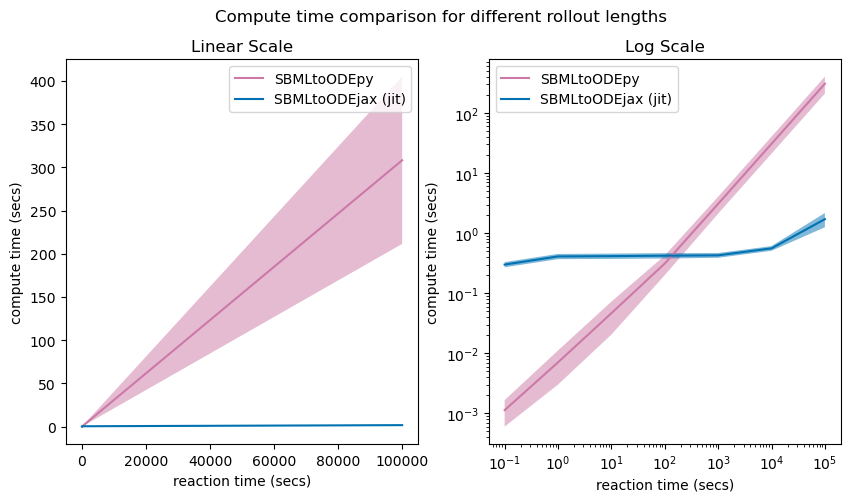

In [7]:
all_jax_times = []
all_py_times = []
for model_idx in all_model_ids:
    jax_times = [compute_time['jax'][model_idx][1][n_secs] for n_secs in all_n_secs]
    py_times = [compute_time['py'][model_idx][1][n_secs] for n_secs in all_n_secs] 
    all_jax_times.append(jax_times)
    all_py_times.append(py_times)
all_jax_times = np.asarray(all_jax_times)
all_py_times = np.asarray(all_py_times)

jax_ymean = all_jax_times.mean(0)
jax_ystd = all_jax_times.std(0)
py_ymean = all_py_times.mean(0)
py_ystd = all_py_times.std(0)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.array(all_n_secs) 
for i in range(2):
    ax[i].plot(x, py_ymean, color=default_colors[0], label="SBMLtoODEpy")
    ax[i].fill_between(x, py_ymean+py_ystd, py_ymean-py_ystd, facecolor=default_colors[0], alpha=0.5)
    ax[i].plot(x, jax_ymean, color=default_colors[1], label="SBMLtoODEjax (jit)")
    ax[i].fill_between(x, jax_ymean+jax_ystd, jax_ymean-jax_ystd, facecolor=default_colors[1], alpha=0.5)
    ax[i].set_xlabel("reaction time (secs)")
    ax[i].set_ylabel("compute time (secs)")
    ax[i].legend()
ax[0].set_title("Linear Scale")
ax[1].set_title("Log Scale")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.suptitle("Compute time comparison for different rollout lengths")
plt.show()

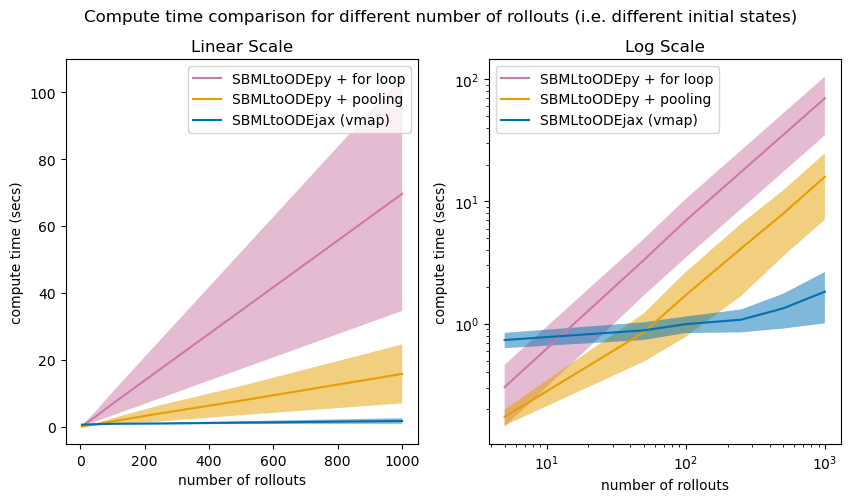

In [8]:
all_jax_times = []
all_py_times = []
all_py_pool_times = []
for model_idx in all_model_ids:
    jax_times = [compute_time['jax'][model_idx][n_in_parallel][10] for n_in_parallel in all_n_in_parallel]
    py_times = [compute_time['py'][model_idx][n_in_parallel][10] for n_in_parallel in all_n_in_parallel]
    py_pool_times = [compute_time['py_pool'][model_idx][n_in_parallel][10] for n_in_parallel in all_n_in_parallel]
    all_jax_times.append(jax_times)
    all_py_times.append(py_times)
    all_py_pool_times.append(py_pool_times)
all_jax_times = np.asarray(all_jax_times)
all_py_times = np.asarray(all_py_times)
all_py_pool_times = np.asarray(all_py_pool_times)

jax_ymean = all_jax_times.mean(0)
jax_ystd = all_jax_times.std(0)
py_ymean = all_py_times.mean(0)
py_ystd = all_py_times.std(0)
py_pool_ymean = all_py_pool_times.mean(0)
py_pool_ystd = all_py_pool_times.std(0)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.array(all_n_in_parallel) 
for i in range(2):
    ax[i].plot(x, py_ymean, color=default_colors[0], label="SBMLtoODEpy + for loop")
    ax[i].fill_between(x, py_ymean+py_ystd, py_ymean-py_ystd, facecolor=default_colors[0], alpha=0.5)
    ax[i].plot(x, py_pool_ymean, color=default_colors[2], label="SBMLtoODEpy + pooling")
    ax[i].fill_between(x, py_pool_ymean+py_pool_ystd, py_pool_ymean-py_pool_ystd, facecolor=default_colors[2], alpha=0.5)
    ax[i].plot(x, jax_ymean, color=default_colors[1], label="SBMLtoODEjax (vmap)")
    ax[i].fill_between(x, jax_ymean+jax_ystd, jax_ymean-jax_ystd, facecolor=default_colors[1], alpha=0.5)
    ax[i].set_xlabel("number of rollouts")
    ax[i].set_ylabel("compute time (secs)")
    ax[i].legend()
ax[0].set_title("Linear Scale")
ax[1].set_title("Log Scale")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.suptitle("Compute time comparison for different number of rollouts (i.e. different initial states)")
plt.show()

## Benchmark limitations

* with sbmltoodepy but other tools might be more performant (e.g. tellurium) 
* impact/precision of chosen solver: https://www.nature.com/articles/s41598-021-82196-2  